# Predict the effect of Genetic Variants

In [1]:
from __future__ import print_function
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


## 1. Loading Data

In [2]:
""" Read Data """
train_variant = pd.read_csv("../input/training_variants")
test_variant = pd.read_csv("../input/test_variants")
train_text = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("../input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
train = pd.merge(train_variant, train_text, how='left', on='ID')
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)
train_size=len(train_x)
print('Number of training variants: %d' % (train_size))
# number of train data : 3321

test_x = pd.merge(test_variant, test_text, how='left', on='ID')
test_size=len(test_x)
print('Number of test variants: %d' % (test_size))
# number of test data : 5668

test_index = test_x['ID'].values
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]

Number of training variants: 3321
Number of test variants: 5668


In [3]:
all_data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


## 2. Data Preprocessing

In [4]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

allText = all_data['Text'].apply(cleanup)
sentences = constructLabeledSentences(allText)
allText.head()

0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [5]:
sentences[0]

LabeledSentence(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'synd

## 3. Data Preparation and Features Extraction

### 3.1 Text Featurizer using Doc2Vec

Training Doc2Vec with your data or import a saved file

In [6]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300


text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

Featurize text for your training and testing dataset 

In [7]:
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1
    
print(text_train_arrays[0][:50])

[ 0.05595167 -0.52335     0.56181264  0.81017768 -0.09576434  0.10710832
  0.35364419 -0.40049207  0.20168397 -0.66067922  0.61090332  0.01016769
  0.11081161 -0.27025095 -0.93801606  0.88014925  0.65283793  0.81476074
 -0.14906819  0.72264481  1.19668019  0.16677573 -0.90955061 -0.42047942
 -0.6978094  -0.7591567   1.28853726  0.59702867  0.17539662  0.38834122
 -0.38319612  0.74040204 -0.0515392   0.31186825  0.69237179  0.25119603
  0.24980347 -0.4826377  -0.52186012  0.05194478 -0.29160628 -0.05996068
  1.11547172 -0.55931973  0.3747184  -1.41338432  0.38505507  0.75241351
 -0.00389227 -1.83658504]


### 3.2 Gene and Varation Featurizer

In [8]:
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

### 3.3 Output class encoding

In [9]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]


### 3.4 Merge Input features

In [10]:
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))
print(train_set[0][:50])

[ -3.82101941e-26   6.24654069e-21   3.44242153e-21   7.38163983e-22
   4.83905842e-22  -2.09970904e-23   1.04438339e-25  -6.96138103e-26
   1.37670503e-29   2.74139817e-29  -1.26973581e-29  -1.11749521e-29
   4.14983888e-29  -2.78276433e-28   2.75335366e-28  -4.66095016e-28
  -5.32141595e-28   1.58956331e-27   4.37764174e-27   2.14378646e-27
  -1.60520217e-26   2.35020386e-26  -3.93126357e-26  -1.72887357e-25
   1.87777680e-25   1.00000000e+00   1.93975499e-18  -2.21176942e-19
   1.91938141e-27   3.68479879e-27   3.03922397e-24   2.22746308e-22
   4.51976792e-22  -9.38556541e-21  -1.08210615e-20  -6.75282630e-21
   2.01905928e-20  -1.76148081e-20  -1.72720056e-21   9.23151807e-18
  -7.57506685e-17   6.78712704e-17  -6.70409692e-18  -2.57001928e-17
   8.66198118e-17  -8.52939536e-17   1.29450480e-16   5.56353843e-17
  -2.07286169e-17  -1.30352154e-17]


## 4. Define Keras Model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [12]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=350, activation="relu", kernel_initializer="normal")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`
  if sys.path[0] == '':


## 5. Training and Evaluating the Model

Create estimator for training the model

In [13]:
estimator=model.fit(train_set, encoded_y, validation_split=0.2, epochs=10, batch_size=64)

Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 [==============================] - 0s - loss: 1.9693 - acc: 0.2684 - val_loss: 2.0102 - val_acc: 0.1444
Epoch 2/10
2656/2656 [==============================] - 0s - loss: 1.7853 - acc: 0.3400 - val_loss: 1.8258 - val_acc: 0.3368
Epoch 3/10
2656/2656 [==============================] - 0s - loss: 1.6378 - acc: 0.4044 - val_loss: 1.6779 - val_acc: 0.3504
Epoch 4/10
2656/2656 [==============================] - 0s - loss: 1.5143 - acc: 0.4431 - val_loss: 1.6274 - val_acc: 0.3850
Epoch 5/10
2656/2656 [==============================] - 0s - loss: 1.4493 - acc: 0.4703 - val_loss: 1.6689 - val_acc: 0.3489
Epoch 6/10
2656/2656 [==============================] - 0s - loss: 1.4061 - acc: 0.4849 - val_loss: 1.6951 - val_acc: 0.3353
Epoch 7/10
2656/2656 [==============================] - 0s - loss: 1.3429 - acc: 0.5053 - val_loss: 1.7148 - val_acc: 0.3474
Epoch 8/10
2656/2656 [==============================] - 0s - loss: 1.2894 - ac

Final model accuracy

In [14]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 55.99% / Validation accuracy: 36.24%


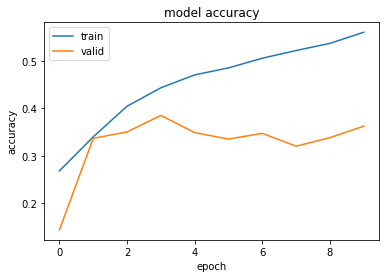

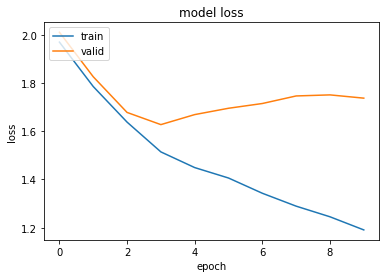

In [15]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 6. Make Predictions

In [16]:
y_pred = model.predict_proba(test_set)

5184/5668 [==========================>...] - ETA: 0s

Make Submission File

In [17]:
submission = pd.DataFrame(y_pred)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv("submission_all.csv",index=False)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.001432,0.222685,0.010984,0.001953,0.012934,0.027559,0.720079,0.000998,0.001376,0
1,0.304507,0.004440,0.008275,0.624737,0.023724,0.025614,0.005134,0.000871,0.002699,1
2,0.241531,0.207713,0.017612,0.048552,0.052141,0.118546,0.282474,0.011315,0.020116,2
3,0.001093,0.326783,0.002720,0.000715,0.005146,0.009676,0.653058,0.000293,0.000517,3
4,0.415650,0.000309,0.001695,0.557500,0.009392,0.014496,0.000492,0.000086,0.000380,4


## 7. Layers Visualization

In [18]:
from keras import backend as K
import seaborn as sns

layer_of_interest=0
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[layer_of_interest].output])
intermediate_tensor = intermediate_tensor_function([train_set[0,:].reshape(1,-1)])[0]


In [19]:
import matplotlib
colors = list(matplotlib.colors.cnames)

intermediates = []
color_intermediates = []
for i in range(len(train_set)):
    output_class = np.argmax(encoded_y[i,:])
    intermediate_tensor = intermediate_tensor_function([train_set[i,:].reshape(1,-1)])[0]
    intermediates.append(intermediate_tensor[0])
    color_intermediates.append(colors[output_class])

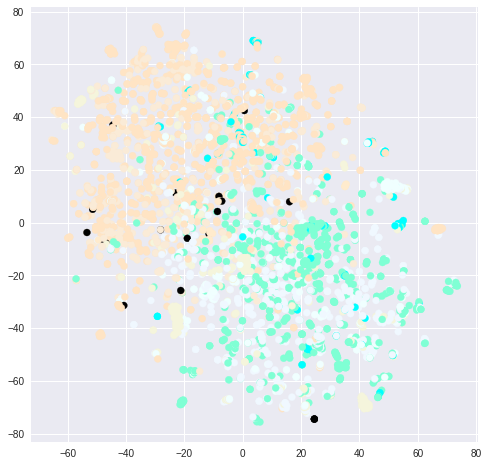

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()